<a href="https://colab.research.google.com/github/LugoBlogger/MLCC-Assignment-05/blob/dev%2F26032020/medical_cost_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

* motivation why we choose that dataset.
* what we want to predict.
* is it interesting enough or not.

In [1]:
# Use seaborn for pairplot
!pip install -q seaborn

# Use some functions from tensorflow_docs
!pip install -q git+https://github.com/tensorflow/docs

In [3]:
# Use tensorflow 2
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [5]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.1.0


In [0]:
### this library is for callback functions
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

# Medical Cost Personal Datasets

## Retrieve the dataset

Manage the dataset into pandas' DataFrame.

In [111]:
dataset = pd.read_csv("https://raw.githubusercontent.com/LugoBlogger/MLCC-Assignment-05/master/datasets/insurance.csv", header=0)
dataset

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


## Clean the data

Checking the dataset whether is clean or not.

In [112]:
dataset.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Convert categorical columns into numeric with the following convention:

* `sex`: male = 1, female = 2,

* `smoker`: yes = 1, no = 0,

* `region`: northeast = $\displaystyle\frac{\pi}{4}$, northwest = $\displaystyle\frac{3\pi}{4}$, southwest = $\displaystyle\frac{5\pi}{4}$, southeast = $\displaystyle\frac{7\pi}{4}$. We use the representation of direction by their angle on unit circle. If we compute the method `.mean`, it will make a sense (where is the region whose citizens are the most recorded).

In [113]:
dataset.loc[dataset['sex'] == 'male', 'sex'] = 1
dataset.loc[dataset['sex'] == 'female', 'sex'] = 2

dataset.loc[dataset['smoker'] == 'yes', 'smoker'] = 1
dataset.loc[dataset['smoker'] == 'no', 'smoker'] = 0

dataset.loc[dataset['region'] == 'northeast', 'region'] = np.pi/4
dataset.loc[dataset['region'] == 'northwest', 'region'] = 3*np.pi/4
dataset.loc[dataset['region'] == 'southwest', 'region'] = 5*np.pi/4
dataset.loc[dataset['region'] == 'southeast', 'region'] = 7*np.pi/4

train_dataset['region'] = pd.to_numeric(train_dataset['region'])

dataset

,age,sex,bmi,children,smoker,region,charges
0,19,2,27.900,0,1,3.92699,16884.92400
1,18,1,33.770,1,0,5.49779,1725.55230
2,28,1,33.000,3,0,5.49779,4449.46200
3,33,1,22.705,0,0,2.35619,21984.47061
4,32,1,28.880,0,0,2.35619,3866.85520
...,...,...,...,...,...,...,...
1333,50,1,30.970,3,0,2.35619,10600.54830
1334,18,2,31.920,0,0,0.785398,2205.98080
1335,18,2,36.850,0,0,5.49779,1629.83350
1336,21,2,25.800,0,0,3.92699,2007.94500


## Split the data into a training set and a test set.

In [114]:
train_dataset = dataset.sample(frac=0.8, random_state=2020)
test_dataset = dataset.drop(train_dataset.index)

N_train = len(train_dataset)
N_test = len(test_dataset)
print('N_train:', N_train)
print('N_test:', N_test)
print('N_train/N_dataset:', N_train/len(dataset))

N_train: 1070
N_test: 268
N_train/N_dataset: 0.7997010463378177


## Inspect the data

We look at the joint distribution of a few pairs of columns from the training set. The diagonal elements represent kerned density estimation (kde) for univariate variables for given columns. We include all the columns to inspect which variable has a correlation to another variable

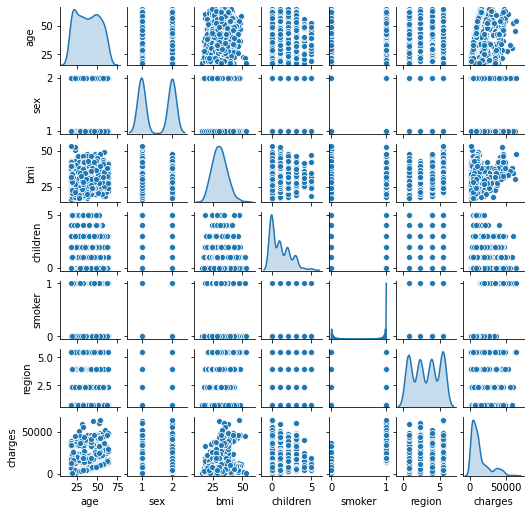

In [115]:
sns.pairplot(train_dataset[['age', 'sex', 'bmi', 'children', 'smoker', 
                            'region', 'charges']], 
             diag_kind='kde', height=1);

In [116]:
train_dataset

,age,sex,bmi,children,smoker,region,charges
1293,46,1,25.745,3,0,2.35619,9301.89355
361,35,1,30.500,1,0,3.92699,4751.07000
802,21,1,22.300,1,0,3.92699,2103.08000
623,18,1,33.535,0,1,0.785398,34617.84065
735,49,2,34.770,1,0,2.35619,9583.89330
...,...,...,...,...,...,...,...
979,36,2,29.920,0,0,5.49779,4889.03680
162,54,1,39.600,1,0,3.92699,10450.55200
171,49,1,30.300,0,0,3.92699,8116.68000
265,46,1,42.350,3,1,5.49779,46151.12450


If we look at the above table, we see that BMI and charges have an intriguing pattern.

We also inspect at their statistical description:

In [120]:
train_stats = train_dataset.describe()
train_stats.pop('charges')

# for pretty output
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
age,1070.0,38.943925,14.062091,18.000000,26.000000,39.000000,51.000000,64.000000
sex,1070.0,1.495327,0.500212,1.000000,1.000000,1.000000,2.000000,2.000000
bmi,1070.0,30.696785,6.157567,15.960000,26.237500,30.400000,34.700000,53.130000
children,1070.0,1.080374,1.206890,0.000000,0.000000,1.000000,2.000000,5.000000
smoker,1070.0,0.203738,0.402965,0.000000,0.000000,0.000000,0.000000,1.000000
region,1070.0,3.182698,1.799384,0.785398,0.785398,3.926991,5.497787,5.497787


### Split features from labels

Separate the target value, or "label", from features. In this case, we assume our target value is `charges`.

In [0]:
# Remember that .pop method will extract the value not the labels!

train_labels = train_dataset.pop('charges')
test_labels = test_dataset.pop('charges')

### Normalize the data

In [0]:
def normalize(x_val):
  return (x_val - train_stats['mean']) / train_stats['std']

normed_train_data = normalize(train_dataset)
normed_test_data = normalize(test_dataset)